### Prevendo Ações - (Problema de Regressão)

In [1]:
import pandas as pd
from pandas import Series
from pandas import DataFrame,concat
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [2]:
# Dando carga nos dados
from datetime import datetime

# CREATE TICKER INSTANCE FOR AMAZON
data = yf.Ticker("PETR4.SA")

# GET TODAYS DATE AND CONVERT IT TO A STRING WITH YYYY-MM-DD FORMAT (YFINANCE EXPECTS THAT FORMAT)
end_date = datetime.now().strftime('%Y-%m-%d')
data = data.history(start='2020-01-01',end=end_date)
data = data['Close']
print(data)

Date
2020-01-02 00:00:00-03:00    14.581382
2020-01-03 00:00:00-03:00    14.462639
2020-01-06 00:00:00-03:00    14.633624
2020-01-07 00:00:00-03:00    14.576630
2020-01-08 00:00:00-03:00    14.486386
                               ...    
2023-02-24 00:00:00-03:00    25.900000
2023-02-27 00:00:00-03:00    26.150000
2023-02-28 00:00:00-03:00    25.240000
2023-03-01 00:00:00-03:00    25.299999
2023-03-02 00:00:00-03:00    24.639999
Name: Close, Length: 787, dtype: float64


In [3]:
# Vamos extrair features e montar um dataset para previsão de valores absolutos de bitcoins.
# exemplo de features para sliding window
prices = data
width  = 3
window = prices.rolling(window=width)
dataframe = concat([window.min(), window.mean(),window.std(), window.max(),prices.shift(3),prices.shift(2),prices.shift(1), prices], axis=1)
dataframe.columns = ['min', 'mean', 'std','max','t-2','t-1','t', 't+1']
print(dataframe.head(5))

                                 min       mean       std        max  \
Date                                                                   
2020-01-02 00:00:00-03:00        NaN        NaN       NaN        NaN   
2020-01-03 00:00:00-03:00        NaN        NaN       NaN        NaN   
2020-01-06 00:00:00-03:00  14.462639  14.559215  0.087621  14.633624   
2020-01-07 00:00:00-03:00  14.462639  14.557631  0.087061  14.633624   
2020-01-08 00:00:00-03:00  14.486386  14.565547  0.074242  14.633624   

                                 t-2        t-1          t        t+1  
Date                                                                   
2020-01-02 00:00:00-03:00        NaN        NaN        NaN  14.581382  
2020-01-03 00:00:00-03:00        NaN        NaN  14.581382  14.462639  
2020-01-06 00:00:00-03:00        NaN  14.581382  14.462639  14.633624  
2020-01-07 00:00:00-03:00  14.581382  14.462639  14.633624  14.576630  
2020-01-08 00:00:00-03:00  14.462639  14.633624  14.576630  14.

In [4]:
# alternativa
# Dependendo do problema, prever valores absolutos ( ou mesmo normalizando posteriormente) pode ser difícil.
# podemos tentar prver uma variação com relação a uma tendência local numa janela (ex. média local numa janela)
prices    = data
width     = 3
window    = prices.rolling(window=width)
variation = (prices - window.mean())/window.mean()
window_rol =  variation.rolling(window=width)
# abaixo o framework
#window = shifted.rolling(window=width)
dataframe = concat([variation.shift(3),variation.shift(2),variation.shift(1), variation], axis=1)
features = ['t-2','t-1','t']
dataframe.columns = features + ['t+1']
# outra forma...
vmean = dataframe[features].mean(axis=1)
vmax  = dataframe[features].max(axis=1)
vmin  = dataframe[features].min(axis=1)
vstd  = dataframe[features].std(axis=1)
dataframe = concat([vmin,vmean,vstd,vmax,dataframe], axis=1)
features = ['min', 'mean', 'std','max'] + features 
dataframe.columns = features + ['t+1']
print(dataframe.head(5))

                                min      mean       std       max  t-2  \
Date                                                                     
2020-01-02 00:00:00-03:00       NaN       NaN       NaN       NaN  NaN   
2020-01-03 00:00:00-03:00       NaN       NaN       NaN       NaN  NaN   
2020-01-06 00:00:00-03:00       NaN       NaN       NaN       NaN  NaN   
2020-01-07 00:00:00-03:00  0.005111  0.005111       NaN  0.005111  NaN   
2020-01-08 00:00:00-03:00  0.001305  0.003208  0.002691  0.005111  NaN   

                                t-1         t       t+1  
Date                                                     
2020-01-02 00:00:00-03:00       NaN       NaN       NaN  
2020-01-03 00:00:00-03:00       NaN       NaN       NaN  
2020-01-06 00:00:00-03:00       NaN       NaN  0.005111  
2020-01-07 00:00:00-03:00       NaN  0.005111  0.001305  
2020-01-08 00:00:00-03:00  0.005111  0.001305 -0.005435  


In [5]:
# É preciso substituir os nans por algum valor, Colocamos zero
# Dependerá dos dados do seu problema.
dataframe = dataframe.fillna(value=0)  
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error

regr = RandomForestRegressor(random_state=0)

X = dataframe.drop(['t+1'],axis=1).values
y = dataframe['t+1'].values
nsplits  = len(dataframe)-1 

tscv = TimeSeriesSplit(n_splits=nsplits,max_train_size=100) # pode-se limitar a janela max_train_size
r_true = []
r_pred = []

mae = []
mape = [] # só faz sentido medir se a previsão for o dado bruto e não a previ~soa relativa com a média.
for train_index, test_index in tscv.split(X):
    if len(train_index)<50: 
        continue
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regr.fit(X_train, y_train) 
    y_pred = regr.predict(X_test)
    r_true += [y_test]
    r_pred += [y_pred]

    mae  += [mean_absolute_error(r_true,r_pred) ]
    mape += [np.mean(np.abs((np.asarray(r_true) - np.asarray(r_pred)) / np.asarray(r_true))) * 100]

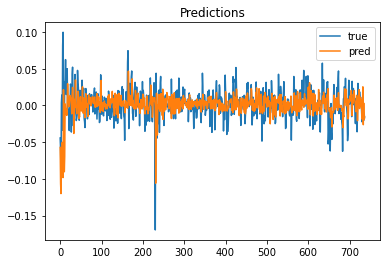

In [6]:
plt.plot(range(len(r_true)), r_true, label='true')
plt.plot(range(len(r_pred)), r_pred, label='pred')
plt.legend(loc='best')
plt.title('Predictions')
plt.show()

avg of mae 0.019847222013640253


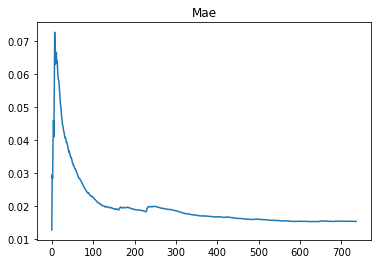

In [7]:
print("avg of mae",np.mean(mae))
plt.plot(range(len(mae)), mae)
plt.title('Mae')
plt.show()

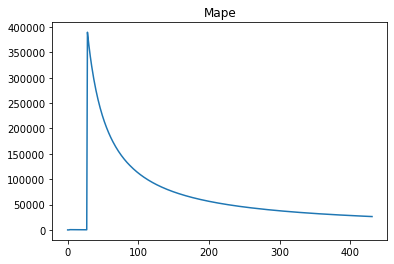

In [8]:
# só faz sentido para previsão de valores absolutos! a primeira forma de processamento. 
# A segunda forma (previsão de variação, não é adequada para esta)
plt.plot(range(len(mape)), mape)
plt.title('Mape')
plt.show()

### Prevendo Ações - (Problema de Classificação)

In [9]:
# O problema como regressão é difícil! que tal tratarmos como classificação?
# Fazer em lab e analisra como classificação!

In [10]:
limiar = 0.005
variation[(variation > -limiar) & (variation < limiar)] = 0
variation[variation > limiar] = 1
variation[variation < -limiar] = -1
dataframe['variation'] = variation

In [11]:
# É preciso substituir os nans por algum valor, Colocamos zero
dataframe = dataframe.fillna(value=0)  
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report

clf = RandomForestClassifier(random_state=0)

X = dataframe.drop(['t+1'],axis=1).values
y = dataframe['variation'].values
nsplits  = len(dataframe)-1 

tscv = TimeSeriesSplit(n_splits=nsplits,max_train_size=100) # pode-se limitar a janela max_train_size
r_true = []
r_pred = []

for train_index, test_index in tscv.split(X):
    if len(train_index)<50: 
        continue
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test)
    r_true += [y_test]
    r_pred += [y_pred]

In [12]:
target_names = ['0', '1', '-1']
print(classification_report(r_true, r_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       244
           1       0.97      0.98      0.98       183
          -1       1.00      1.00      1.00       310

    accuracy                           0.99       737
   macro avg       0.99      0.99      0.99       737
weighted avg       0.99      0.99      0.99       737

